In [1]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
from os import path
from torchvision import transforms
import numpy as np

# First test implementation

## Costruction of dataset

- `all_labels.txt`: All image's labels of all entire dataset
- `classes.txt`: classes
- `test.txt`: test dataset
- `test.txt`: train dataset 

In [2]:
class TrashbeanDataset(Dataset):
    def __init__(self, base_path, txt_list, transform=None):
        IMG_CHANNEL = 3

        self.txt_list = txt_list ## utile per la normalizzazione

        self.base_path = base_path
        self.images = np.loadtxt(txt_list, dtype=str, delimiter=',')
        self.mean = np.zeros(IMG_CHANNEL)
        self.dev_std = np.zeros(IMG_CHANNEL)

        self.transform = transform

    def __getitem__(self, index):
        f,c = self.images[index] # recuperiamo il path dell'immagine di indice index e la relativa etichetta
        im = Image.open(path.join(self.base_path, f))   ## load img with PIL

        if self.transform is not None:          ## toTensor, resize, normalize etc...
            im = self.transform(im)

        label = int(c) # converto l'etichetta in intero

        return {'image': im, 'label': label}    # return dictionary --> immagine : etichetta

    def _bef_normalize(self):
        for sample in self:
            self.mean += sample['image'].sum(1).sum(1).numpy() ## accumulo somma dei pixel canale per canale

        self.mean = self.mean / ( len(self)*256*256 )

        for sample in self:
            self.dev_std += ( ( sample['image'] - torch.Tensor(self.mean).view(3,1,1) )**2).sum(1).sum(1).numpy()

        self.dev_std = np.sqrt(self.dev_std/(len(self)*256*256))

    # permutazione randomica
    def __random__(self):
        np.random.seed(123)
        np.random.shuffle(self.images)

    # restituisce numero di campioni: la lunghezza della lista images
    def __len__(self):
        return len(self.images)

Carichiamo il dataset completo e applichiamo una permutazione dividendo tra train e test

In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

transform = transforms.ToTensor()

dataset_train = TrashbeanDataset('static/datasets/img', 'static/datasets/train.txt', transform=transform) # can put (w,h) too
dataset_test = TrashbeanDataset('static/datasets/img', 'static/datasets/test.txt', transform=transform) # can put (w,h) too

print("dim totale dataset train", dataset_train.__len__())
print("img 1", dataset_train[0]['image'].shape, dataset_train[0]['label'])

dim totale dataset train 350
img 1 torch.Size([3, 1920, 1080]) -1


Visualizziamo un esempio:

torch.Size([3, 1920, 1080]) <class 'torch.Tensor'>


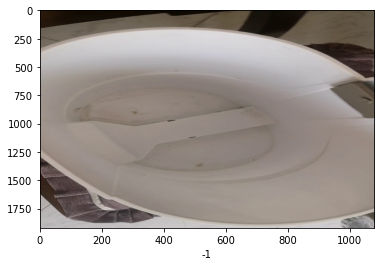

In [4]:
## visualizziamo un esempio:
print(dataset_train[0]['image'].shape, type(dataset_train[0]['image']))
plt.imshow(dataset_train[0]['image'].permute(1, 2, 0),aspect="auto")
plt.xlabel(dataset_train[0]['label'])
plt.show()

Prima di normalizzare e dividere il dataset ranomizzato in training e test utilizzando la funzion di sklearn calcoliamo media e dv std delle immagini originali senza rescaling

In [5]:
mean_train = dataset_train.mean
dev_std_train = dataset_train.dev_std

mean_test = dataset_test.mean
dev_std_test = dataset_test.dev_std

## calcoliamo media e dv standard prima di normalizzare e fare il resize dell'immagine

print("==== before calculated train\nmean:", dataset_train.mean,"\ndev_std:", dataset_train.dev_std)
dataset_train._bef_normalize()

print("==== before calculated test\nmean:", dataset_test.mean,"\ndev_std:", dataset_test.dev_std)
dataset_test._bef_normalize()

print("==== after calculated train\nmean:", dataset_train.mean,"\ndev_std:", dataset_train.dev_std)
print(mean_train, dev_std_train)

print("==== after calculated test\nmean:", dataset_test.mean,"\ndev_std:", dataset_test.dev_std)
print(mean_test, dev_std_test)

# nota::: to understand the difference between the norm and none comment transform.normalize & torch.flatten
## normaliz = transforms.Compose([ transforms.Resize(28), transforms.ToTensor() ])

# carico dataset normalizzato
dataset_train_norm = TrashbeanDataset('static/datasets/img', 'static/datasets/train.txt', transform=transforms.Compose([ transforms.Resize(28), transforms.ToTensor(), transforms.Normalize(mean_train, dev_std_train), torch.flatten ]) )
dataset_test_norm = TrashbeanDataset('static/datasets/img', 'static/datasets/test.txt', transform=transforms.Compose([ transforms.Resize(28), transforms.ToTensor(), transforms.Normalize(mean_test, dev_std_test), torch.flatten ]) )

==== before calculated train
mean: [0. 0. 0.] 
dev_std: [0. 0. 0.]
==== before calculated test
mean: [0. 0. 0.] 
dev_std: [0. 0. 0.]
==== after calculated train
mean: [16.10784641 14.92519372 13.80825097] 
dev_std: [87.75288881 81.31016524 75.22799202]
[3.69475338e+08 3.42348123e+08 3.16728138e+08] [1.76632583e+11 1.51648341e+11 1.29809631e+11]
==== after calculated test
mean: [15.6746951  14.72301073 13.64667786] 
dev_std: [85.3935748  80.2086273  74.34752893]
[1.54088523e+08 1.44733085e+08 1.34152302e+08] [7.16838924e+10 6.32431302e+10 5.43380772e+10]


Controlliamo l'immagine alla prima posizione, applichiamo una permutazione randomica agli inidici e controlliamo nuovamente il corrispondente elemento:


## come si fa a passare da un'immagine torch.Tensor normalizzata a un'immagine normale per farla vedere in matplotlib?

necessario rifare la permutazione dato che già è stato randomizzato il dataset prima?

In [15]:

## print(type(dataset_norm[0]['image']), type(dataset_norm[0]['label']))

## plt.imshow((dataset_norm[0]['image']).permute(1, 2, 0),aspect="auto")
## plt.xlabel(dataset_norm[0]['label'])
## plt.show()

# permutazione randomica del dataset
## dataset_norm.__random__() ## si deve fare dopo

# plt.imshow(dataset_norm[0]['image'].permute(1, 2, 0),aspect="auto")
# plt.xlabel(dataset_norm[0]['label'])
# plt.show()

<class 'torch.Tensor'> <class 'int'>


Visualizzo i dati e controllo che siano stati splittati correttamente:

## come ritorniamo all'immagine per farla visualizzare? (dopo aver applicato normalizzazione e flatten)

Flattens input by reshaping it into a one-dimensional tensor. If start_dim or end_dim are passed, only dimensions starting with start_dim and ending with end_dim are flattened. The order of elements in input is unchanged.

In [17]:
## cambia il nome perché è col codice vecchio

## commento per evitare errore ## plt.imshow(test_data[0]['image'].permute(1, 2, 0),aspect="auto")
## commento per evitare errore ## plt.xlabel(test_data[0]['label'])
## commento per evitare errore ## plt.show()
## commento per evitare errore ## 
## commento per evitare errore ## plt.imshow(training_data[0]['image'].permute(1, 2, 0),aspect="auto")
## commento per evitare errore ## plt.xlabel(training_data[0]['label'])
## commento per evitare errore ## plt.show()

dimensione training: 350 
dimensione test: 150


In [17]:
from torch.utils.data import DataLoader

## non riusciamo a caricare i batch

print("test", dataset_test_norm[0]['image'], type(dataset_test_norm[0]['image'] ))

print(type(dataset_train_norm), dataset_train_norm.__len__(), dataset_test_norm.__getitem__(0) )
print(type(dataset_test_norm), dataset_test_norm.__len__() )


test_loader = DataLoader(dataset_train_norm, batch_size=150) 

for batch in test_loader:
    print(batch)
    pass

#print(batch[0].shape)
#print(batch[1].shape)


AttributeError: 'dict' object has no attribute 'shape'

- risolvere problema visualizzazione di torch su matplotlib (celle sopra)
- implementare il softmax con mlp